In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets.public_api as tfds

from PIL import Image
from nnflow import flow_to_image

2022-09-28 11:06:19.289107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-28 11:06:19.605508: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-28 11:06:20.576488: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /shared/centos7/cuda/11.3/lib64:/shared/centos7/nodejs/14.15.4/lib
2022-09-28 11:06:20.576605: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.

In [2]:
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
!pwd

/work/vig/prajnan/thesis/optical-flow/notebooks


In [4]:
def plot_video_frames_grid(video_frames):
    video_frames = torch.from_numpy(video_frames.numpy())
    video_frames = video_frames.permute(0,3,1,2)
    plt.figure(figsize=(24,12))
    plt.axis('off')
    plt.imshow(make_grid(video_frames, nrow=8).permute((1, 2, 0)))

In [5]:
def plot_flow_grid(flows):
    flows = flows.numpy()
    flow_color = []
    for flow in flows:
        flow = flow_to_image(flow)
        flow_color.append(flow)
        
    flow_color = np.asarray(flow_color)
    flow_color = torch.from_numpy(flow_color)
    flow_color = flow_color.permute(0,3,1,2)
    grid = make_grid(flow_color, nrow=8).permute((1, 2, 0))
    
    plt.figure(figsize=(24,12))
    plt.axis('off')
    plt.imshow(grid)

In [6]:
# Tensorflow prioritizes loading on GPU by default
# Disable loading on all GPUS
tf.config.set_visible_devices([], 'GPU')

In [7]:
tf.config.list_logical_devices()

2022-09-28 11:06:32.551290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

In [8]:
ds_type = "movi_f"
ds_path = "../../../../Datasets/kubric-public/tfds"
split = "validation"
try:
    ds = tfds.load(ds_type, data_dir=ds_path, split=split, shuffle_files=True)
except:
    print(f"Kubric Dataset {ds_type} not found in location {ds_path}")

In [9]:
type(ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [10]:
ds.cardinality().numpy()

147

In [11]:
sample_count = 147 * 24
sample_count

3528

In [17]:
sample = next(iter(ds))

In [18]:
video_frames = sample['video']
forward_flow = sample['forward_flow']
backward_flow = sample['backward_flow']

In [19]:
video_frames.shape, forward_flow.shape, type(video_frames), type(forward_flow)

(TensorShape([24, 512, 512, 3]),
 TensorShape([24, 512, 512, 2]),
 tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.EagerTensor)

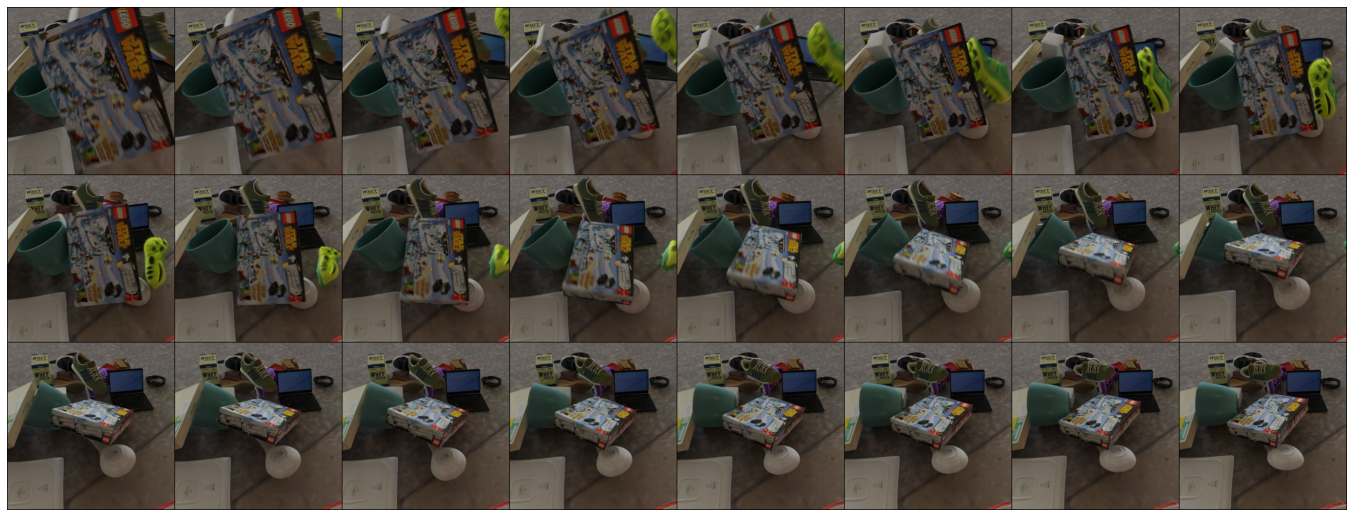

In [20]:
plot_video_frames_grid(video_frames)

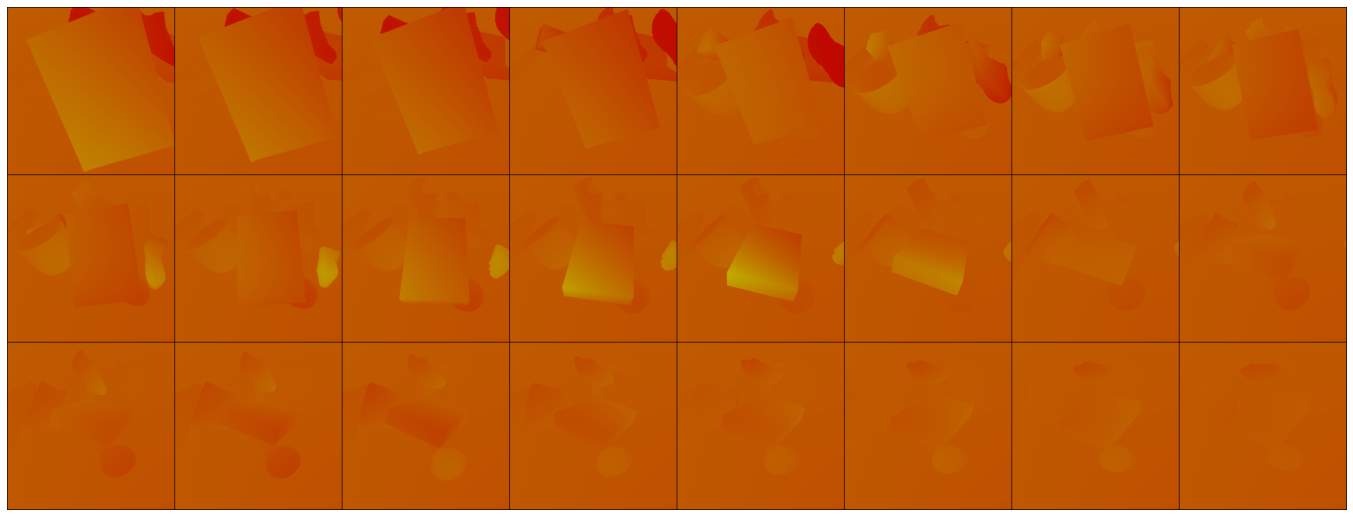

In [21]:
plot_flow_grid(forward_flow)

____

# Kubric Dataset Pytorch Wrapper

In [1]:
import random
import sys
import numpy as np
import torch
import torch.utils.data as data
import torchvision.transforms as transforms

import tensorflow as tf
import tensorflow_datasets.public_api as tfds

from ezflow.functional import FlowAugmentor, Normalize, crop

2022-09-28 10:57:57.783413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-28 10:57:58.154576: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-28 10:57:59.438275: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /shared/centos7/cuda/11.3/lib64:/shared/centos7/nodejs/14.15.4/lib
2022-09-28 10:57:59.438401: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.

In [2]:
class Kubric(data.Dataset):
    """
    Dataset class for preparing Kubric movi-e dataset for optical flow training.

    Parameters
    ----------
    root_dir : str
        path of the root directory for the flying chairs dataset
    split : str, default : "training"
        specify the training or validation split
    init_seed : bool, default : False
        If True, sets random seed to the worker
    is_prediction : bool, default : False
        If True,   If True, only image data are loaded for prediction otherwise both images and flow data are loaded
    append_valid_mask : bool, default :  False
        If True, appends the valid flow mask to the original flow mask at dim=0
    crop: bool, default : True
        Whether to perform cropping
    crop_size : :obj:`tuple` of :obj:`int`
        The size of the image crop
    crop_type : :obj:`str`, default : 'center'
        The type of croppping to be performed, one of "center", "random"
    augment : bool, default : False
        If True, applies data augmentation
    aug_params : :obj:`dict`
        The parameters for data augmentation
    norm_params : :obj:`dict`, optional
        The parameters for normalization
    """

    def __init__(
        self,
        root_dir,
        ds_type="movi_f",
        split="training",
        init_seed=False,
        is_prediction=False,
        append_valid_mask=False,
        crop=False,
        crop_size=(256, 256),
        crop_type="center",
        augment=True,
        aug_params={
            "color_aug_params": {"aug_prob": 0.2},
            "eraser_aug_params": {"aug_prob": 0.5},
            "spatial_aug_params": {"aug_prob": 0.8},
            "translate_params": {"aug_prob": 0.0},
            "rotate_params": {"aug_prob": 0.0},
        },
        sparse_transform=False,
        norm_params={"use": False},
    ):

        self.is_prediction = is_prediction
        self.init_seed = init_seed
        self.append_valid_mask = append_valid_mask
        self.crop = crop
        self.crop_size = crop_size
        self.crop_type = crop_type
        self.sparse_transform = sparse_transform

        self.augment = augment
        self.augmentor = None

        self.normalize = Normalize(**norm_params)
        
        # Tensorflow prioritizes loading on GPU by default
        # Disable loading on all GPUS
        tf.config.set_visible_devices([], 'GPU')
        
        split = "train" if split == "training" else "validation"
        try:
            self.ds = tfds.load(ds_type, data_dir=root_dir, split=split, shuffle_files=True)
            
            self.sample_count = self.ds.cardinality().numpy() * 24
            self.ds_iterator = iter(self.ds)
        except:
            print(f"Kubric Dataset {ds_type} not found in location {ds_path}")
            sys.exit()
        
        if augment:
            self.augmentor = FlowAugmentor(crop_size=crop_size, **aug_params)
        

    def __getitem__(self, index):
        """
        Returns the corresponding images and the flow between them.

        Parameters
        ----------
        index : int
            specify the index location for access to Dataset item

        Returns
        -------
        tuple
            A tuple consisting of ((img1, img2), flow)

            img1 and img2 of shape 3 x H x W.
            flow of shape 2 x H x W if append_valid_mask is False.
            flow of shape 3 x H x W if append_valid_mask is True.
        """

        if not self.init_seed:
            worker_info = torch.utils.data.get_worker_info()
            if worker_info is not None:
                torch.manual_seed(worker_info.id)
                np.random.seed(worker_info.id)
                random.seed(worker_info.id)
                self.init_seed = True
        
        try:
            sample = next(self.ds_iterator)
        except:
            self.ds_iterator = iter(self.ds)
            sample = next(self.ds_iterator)
            
        video = sample['video'].numpy()
        flows = sample['forward_flow'].numpy()
        
        max_index = video.shape[0] - 2
        random_index = np.random.randint(0, max_index)
        
        img1, img2 = video[random_index].copy(), video[random_index+1].copy()
        flow = flows[random_index].copy()
        
        img1 = img1.astype(np.uint8)
        img2 = img2.astype(np.uint8)
        flow = flow.astype(np.float32)
        valid = None
        
        # delete unused variables to free memory
        del video, flows, sample, max_index, random_index
        
        if self.is_prediction:

            img1 = torch.from_numpy(img1).permute(2, 0, 1).float()
            img2 = torch.from_numpy(img2).permute(2, 0, 1).float()

            img1, img2 = self.normalize(img1, img2)
            return img1, img2

        if self.augment is True and self.augmentor is not None:
            img1, img2, flow, valid = self.augmentor(img1, img2, flow, valid)

        if self.crop is True:
            img1, img2, flow, valid = crop(
                img1,
                img2,
                flow,
                valid=valid,
                crop_size=self.crop_size,
                crop_type=self.crop_type,
                sparse_transform=self.sparse_transform,
            )

        img1 = torch.from_numpy(img1).permute(2, 0, 1).float()
        img2 = torch.from_numpy(img2).permute(2, 0, 1).float()
        flow = torch.from_numpy(flow).permute(2, 0, 1).float()
        
        img1, img2 = self.normalize(img1, img2)

        if self.append_valid_mask:
            if valid is not None:
                valid = torch.from_numpy(valid)
            else:
                valid = (flow[0].abs() < 1000) & (flow[1].abs() < 1000)

            valid = valid.float()
            valid = torch.unsqueeze(valid, dim=0)
            flow = torch.cat([flow, valid], dim=0)

        return (img1, img2), flow

    def __len__(self):
        """
        Return length of the dataset.

        """
        return self.sample_count

In [3]:
ds_path = "../../../../Datasets/kubric-public/tfds"
split = "validation"

In [4]:
ds = Kubric(
    root_dir=ds_path,
    init_seed=False,
    split=split, 
    crop=True, 
    crop_size=[368, 496],
    norm_params={"use":True, "mean":[127.5, 127.5, 127.5], "std":[127.5, 127.5, 127.5]}
)

2022-09-28 10:58:07.092236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
len(ds)

3528

In [6]:
(img1, img2), flow = ds[0]
img1.shape, img2.shape, flow.shape

(torch.Size([3, 368, 496]),
 torch.Size([3, 368, 496]),
 torch.Size([2, 368, 496]))

In [7]:
from torch.utils.data.dataloader import DataLoader

In [8]:
dl = DataLoader(
    ds,
    batch_size=10,
    pin_memory=True,
    shuffle=True,
    num_workers=0,
    drop_last=True,
)

In [9]:
count = 0
for inp, target in dl:
    img1, img2 = inp
    print(img1.shape, img2.shape, target.shape)
    count += 1
    
    if count == 5:
        break

torch.Size([10, 3, 368, 496]) torch.Size([10, 3, 368, 496]) torch.Size([10, 2, 368, 496])
torch.Size([10, 3, 368, 496]) torch.Size([10, 3, 368, 496]) torch.Size([10, 2, 368, 496])
torch.Size([10, 3, 368, 496]) torch.Size([10, 3, 368, 496]) torch.Size([10, 2, 368, 496])
torch.Size([10, 3, 368, 496]) torch.Size([10, 3, 368, 496]) torch.Size([10, 2, 368, 496])
torch.Size([10, 3, 368, 496]) torch.Size([10, 3, 368, 496]) torch.Size([10, 2, 368, 496])


___

### EzFlow Dataloader Test for Kubric

In [1]:
from nnflow import CustomDataloaderCreator

2022-09-28 12:07:02.305016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-28 12:07:02.663952: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-28 12:07:03.901537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /shared/centos7/cuda/11.3/lib64:/shared/centos7/nodejs/14.15.4/lib
2022-09-28 12:07:03.901666: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.

In [2]:
loader = CustomDataloaderCreator(
    batch_size=10,
    num_workers=1,
    init_see
    pin_memory=True,
    append_valid_mask=True
)

In [3]:
loader.add_Kubric(
    root_dir="../../../../Datasets/kubric-public/tfds",
    crop=True,
    crop_type="random",
    crop_size=(368, 496),
    split="training",
    augment=True,
    aug_params={
        "spatial_aug_params": {
          "enabled": True,
          "aug_prob": 0.8, 
          "stretch_prob": 0.8, 
          "min_scale": -0.1, 
          "max_scale": 1.0, 
          "max_stretch": 0.2, 
          "flip": True, 
          "h_flip_prob": 0.5, 
          "v_flip_prob": 0.1
        },
        "color_aug_params": {
          "enabled": True,
          "aug_prob": 0.2, 
          "brightness": 0.4, 
          "contrast": 0.4, 
          "saturation": 0.4, 
          "hue": 0.15915494309189535
        },
        "eraser_aug_params": {
          "enabled": True,
          "aug_prob": 0.5,
          "bounds": [50, 100]
        },
        "noise_params":{
          "enabled": False,
          "aug_prob": 0.5,
          "noise_std_range": 0.06 
        },
        "spatial_params": {
          "enabled": False,
          "scale": [0.3, 0.03, 0.1],
          "rot": [0.4, 0.03],
          "trans": [0.4, 0.03],
          "squeeze": [0.3, 0.],
          "black": False
        },
        "translate_params":  {"enabled": False, "aug_prob": 0.0},
        "rotate_params":  {"enabled": False, "aug_prob": 0.0}
    },
    norm_params={"use":True, "mean":[127.5, 127.5, 127.5], "std":[127.5, 127.5, 127.5]}
)

2022-09-28 12:07:12.353588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
loader = loader.get_dataloader()

Total image pairs loaded: 137680/137688



In [5]:
count = 0

for (inp, target) in loader:
    img1, img2 = inp[0], inp[1]
    print(img1.shape, img2.shape, target.shape)
    count += 1
    
    if count == 10:
        break

KeyboardInterrupt: 